# Overview

Here we are simply trying to minimize the root mean square error for predicting the ensemble of 2.5, 16, 50, 84, and 97.5 percentile [O/H] estimates from SDSS spectroscopy. This model is very similar to notebook #2.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Start training ResNeXt

We'll try a 101-layer ResNeXt model similar to the one in the [original paper](https://arxiv.org/abs/1611.05431). The gist of the ResNeXt architecture is to increase "cardinality" in the residual blocks rather than the number of connections (or output channels between layers). In this way, it splits the data into a low-dimensional representation and then re-aggregates it through a neuron. The authors consider this as sticking a **network in a neuron**, analogous to the famous *network-in-network* paper except now in the *next* dimension. 

ResNeXt is able to outperform a deeper ResNet using similar number of computations. The difference between the two can be summarized by their figure 1:

![Xie et al. 2016 Figure 1](https://cdn-images-1.medium.com/max/800/1*mdiQTfovOXKnqzfj727b9Q.png)

In [4]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [7]:
sz = 64
bs = 64
arch = resnext101_64

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

In [10]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [11]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 90%|█████████ | 1080/1200 [01:50<00:12,  9.73it/s, loss=1.94] 

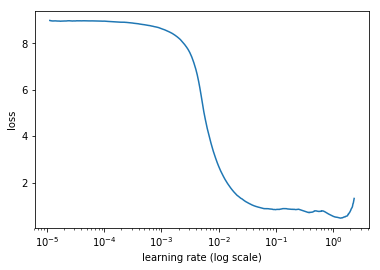

 90%|█████████ | 1080/1200 [02:10<00:14,  8.31it/s, loss=1.94]

In [12]:
learn.lr_find()
learn.sched.plot()

# Begin training

## Start with half-size images

In [13]:
learn.fit(0.1, 2)

epoch      trn_loss   val_loss                                 
    0      0.158501   0.144395  
    1      0.15411    0.140337                                 


[array([0.14034])]

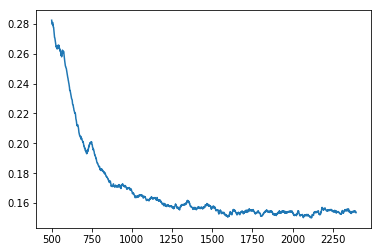

In [15]:
learn.sched.plot_loss(n_skip=500)

In [16]:
learn.save('resnext101-sz64-bs64_init')

## Unfreeze and keep training

 86%|████████▌ | 1030/1200 [04:55<00:48,  3.48it/s, loss=0.531]

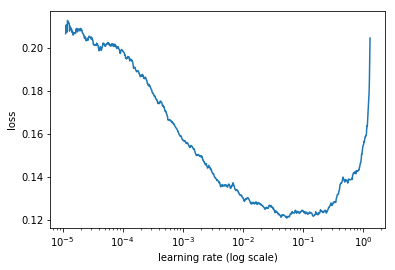

In [17]:
learn.unfreeze()
learn.lr_find()
learn.sched.plot()

### Begin differential learning with lr = [1e-4, 1e-3, 1e-2].

In [19]:
lrs = 1e-2* np.array([1e-2, 1e-1, 1])

learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.128414   0.1252    
    1      0.122282   0.118014                                 
    2      0.116547   0.11348                                  


[array([0.11348])]

Nice! We're getting close to overfitting...

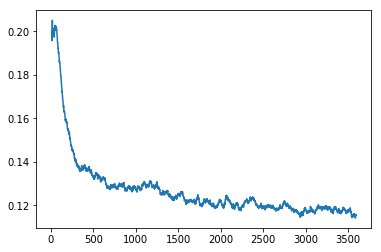

In [22]:
learn.sched.plot_loss()

In [21]:
learn.save('resnext101-sz64-bs64_diff-1')

### Continue training with annealed learning rate

In [23]:
lrs = 1e-2 * np.array([1e-4, 1e-2, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.11497    0.113112  
    1      0.11614    0.113032                                 
    2      0.114964   0.1129                                   
    3      0.114299   0.111421                                 
    4      0.115743   0.111247                                 
    5      0.1137     0.11206                                  
    6      0.113913   0.111197                                 


[array([0.1112])]

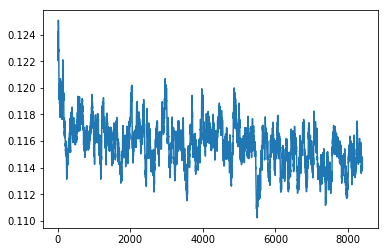

In [24]:
learn.sched.plot_loss()

In [42]:
#learn.save('resnext101-sz64-bs64_diff-2')
learn.load('resnext101-sz64-bs64_diff-2')

In [26]:
p_val, y_val = learn.TTA()
pred_val = np.mean(p_val, axis=0)

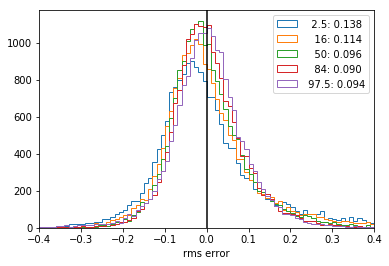

In [30]:
rms_errors = np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

for i in range(5):
    plt.hist(pred_val[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['2.5', '16', '50', '84', '97.5'], rms_errors)]);
plt.xlim(-0.4, 0.4)
plt.axvline(0, c='k')
plt.xlabel('rms error');

In [31]:
df = pd.read_csv(f'{PATH}/catalogs/train-metaldist.csv')
df.sample(5)

,objID,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5
55248,1237654605312491968,8.723296,8.802645,8.856134,8.920353,8.972103
1472,1237668331489394799,8.503127,8.571239,8.613196,8.689143,8.739675
14177,1237658304891453565,9.013613,9.046865,9.088005,9.131633,9.158349
57326,1237655465927966835,8.700703,8.720208,8.730630,8.743601,8.757774
26586,1237657628435480813,9.013940,9.062397,9.070006,9.077616,9.111398


In [38]:
display(df.iloc[val_idxs].oh_p2p5.describe())
display(pd.Series(pred_val[:, 0], name='Predicted 2.5 percentile').describe())

count    19192.000000
mean         8.808307
std          0.267383
min          7.771789
25%          8.701142
50%          8.878770
75%          8.995724
max          9.400133
Name: oh_p2p5, dtype: float64

count    19192.000000
mean         8.813627
std          0.208759
min          7.878779
25%          8.716745
50%          8.886425
75%          8.963842
max          9.374140
Name: Predicted 2.5 percentile, dtype: float64

# Train on full images

In [43]:
sz = 128
bs = 64
data = get_data(sz, bs)

learn.set_data(data)

Hmm...

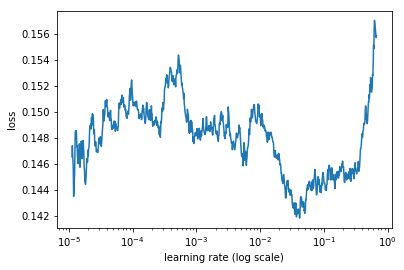

In [40]:
learn.sched.plot(n_skip_end=100)

In [44]:
learn.unfreeze()
lrs = 3e-2 * np.array([1e-4, 1e-2, 1])
learn.fit(lrs, 1)

epoch      trn_loss   val_loss                                 
    0      0.11956    0.113903  


[array([0.1139])]

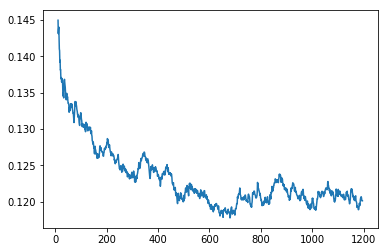

In [45]:
learn.sched.plot_loss()

Does this really take 10 GB of memory? 

In [46]:
learn.save('resnext101-sz64,128-bs64_diff-1')

In [47]:
lrs = 1e-2 * np.array([1e-4, 1e-2, 1])
learn.fit(lrs, 3, cycle_mult=2, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.114748   0.111262  
    1      0.116531   0.110496                                 
    2      0.11311    0.110636                                 
    3      0.114485   0.109836                                 
    4      0.11531    0.109662                                 
    5      0.114449   0.110467                                 
    6      0.111801   0.109612                                 


[array([0.10961])]

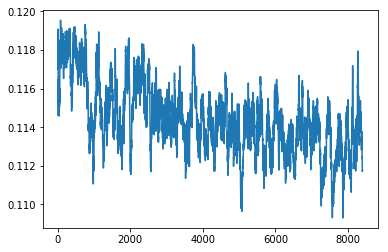

In [48]:
learn.sched.plot_loss()

In [49]:
learn.save('resnext101-sz64,128-bs64_diff-2')